In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 12/10/2020

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 12/10/2020\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt, \
                                  compute_start_end_timestamps_from_days_with_regulations, \
                                  convert_to_one_hot
from generator import extract_features_from_list_days_and_timestamps
from utils_trainingModel import WarmUpCosineDecayScheduler

/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split

In [4]:
# sectorName = 'BOLN'
# sectorName = 'B3EH'
# sectorName = 'D6WH'

sectorName = 'HRHR'
sectorName = 'HSOL'

In [5]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [6]:
num_epochs = 200
batch_size = 32

# Loading the data 

In [7]:
X_train = np.load('./Counting_variables/Weather/X_train.npy')
y_train = np.load('./Counting_variables/Weather/y_train.npy')
X_test = np.load('./Counting_variables/Weather/X_test.npy')
y_test = np.load('./Counting_variables/Weather/y_test.npy')

In [8]:
X_train.shape, y_train.shape

((182, 30, 32), (182, 30, 1))

In [9]:
X_test.shape, y_test.shape

((79, 30, 32), (79, 30, 1))

### Convert labels to single units

In [10]:
y_train = np.sum(y_train, axis = 1)
y_test = np.sum(y_test, axis = 1)

In [11]:
y_train[y_train > 0] = 1
y_test[y_test > 0] = 1

In [12]:
y_train.shape, y_test.shape

((182, 1), (79, 1))

# Train the model

In [13]:
# GRADED FUNCTION: Emojify_V2

def Hotspoter_v1(input_shape):
    
    daily_traffic = Input(shape=input_shape)   
    
    X = LSTM(64, return_sequences=True)(daily_traffic)
    X = Dropout(0.5)(X)
    
    X = LSTM(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(1)(X)
    X = Activation('sigmoid')(X)
    
    model = model = Model(inputs=daily_traffic, outputs=X)
    
    
    return model

In [34]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

model = Hotspoter_v1((num_timestamps_per_sample, 32))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 30, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 64)            24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0   

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    shuffle=True)

Train on 182 samples, validate on 79 samples
Epoch 1/200
182/182 [==============================] - 1s 5ms/step - loss: 0.7260 - accuracy: 0.5165 - val_loss: 0.6404 - val_accuracy: 0.6456
Epoch 2/200
182/182 [==============================] - 0s 1ms/step - loss: 0.6761 - accuracy: 0.5879 - val_loss: 0.6486 - val_accuracy: 0.6456
Epoch 3/200
182/182 [==============================] - 0s 1ms/step - loss: 0.6710 - accuracy: 0.5989 - val_loss: 0.6256 - val_accuracy: 0.6582
Epoch 4/200
182/182 [==============================] - 0s 1ms/step - loss: 0.6538 - accuracy: 0.6099 - val_loss: 0.6146 - val_accuracy: 0.7595
Epoch 5/200
182/182 [==============================] - 0s 1ms/step - loss: 0.6722 - accuracy: 0.6154 - val_loss: 0.6258 - val_accuracy: 0.7848
Epoch 6/200
182/182 [==============================] - 0s 1ms/step - loss: 0.6322 - accuracy: 0.6703 - val_loss: 0.5758 - val_accuracy: 0.8228
Epoch 7/200
182/182 [==============================] - 0s 1ms/step - loss: 0.6001 - accuracy: 0.6

182/182 [==============================] - 0s 1ms/step - loss: 0.2773 - accuracy: 0.8846 - val_loss: 0.4259 - val_accuracy: 0.7722
Epoch 58/200
182/182 [==============================] - 0s 1ms/step - loss: 0.2558 - accuracy: 0.9121 - val_loss: 0.4289 - val_accuracy: 0.7595
Epoch 59/200
182/182 [==============================] - 0s 1ms/step - loss: 0.2356 - accuracy: 0.9286 - val_loss: 0.7137 - val_accuracy: 0.7468
Epoch 60/200
182/182 [==============================] - 0s 1ms/step - loss: 0.2033 - accuracy: 0.9121 - val_loss: 0.4251 - val_accuracy: 0.8101
Epoch 61/200
182/182 [==============================] - 0s 1ms/step - loss: 0.2392 - accuracy: 0.9066 - val_loss: 0.9335 - val_accuracy: 0.7215
Epoch 62/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1904 - accuracy: 0.9396 - val_loss: 0.9989 - val_accuracy: 0.6962
Epoch 63/200
182/182 [==============================] - 0s 1ms/step - loss: 0.2433 - accuracy: 0.9176 - val_loss: 0.4664 - val_accuracy: 0.7975
Epoch

Epoch 114/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1719 - accuracy: 0.9231 - val_loss: 1.0935 - val_accuracy: 0.7089
Epoch 115/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.9451 - val_loss: 0.4109 - val_accuracy: 0.7468
Epoch 116/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1660 - accuracy: 0.9396 - val_loss: 0.8664 - val_accuracy: 0.7342
Epoch 117/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.9231 - val_loss: 0.4907 - val_accuracy: 0.7975
Epoch 118/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1638 - accuracy: 0.9286 - val_loss: 0.5780 - val_accuracy: 0.7722
Epoch 119/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.9451 - val_loss: 1.0388 - val_accuracy: 0.7342
Epoch 120/200
182/182 [==============================] - 0s 1ms/step - loss: 0.2152 - accuracy: 0.9121 - val_loss: 0.6169 - val_ac

182/182 [==============================] - 0s 1ms/step - loss: 0.1198 - accuracy: 0.9615 - val_loss: 1.2609 - val_accuracy: 0.7595
Epoch 171/200
182/182 [==============================] - 0s 1ms/step - loss: 0.0827 - accuracy: 0.9615 - val_loss: 1.2460 - val_accuracy: 0.7722
Epoch 172/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1491 - accuracy: 0.9505 - val_loss: 1.0409 - val_accuracy: 0.7595
Epoch 173/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1305 - accuracy: 0.9451 - val_loss: 1.1222 - val_accuracy: 0.7215
Epoch 174/200
182/182 [==============================] - 0s 1ms/step - loss: 0.1224 - accuracy: 0.9505 - val_loss: 1.2209 - val_accuracy: 0.7342
Epoch 175/200
182/182 [==============================] - 0s 1ms/step - loss: 0.0916 - accuracy: 0.9615 - val_loss: 1.5667 - val_accuracy: 0.7342
Epoch 176/200
182/182 [==============================] - 0s 1ms/step - loss: 0.0928 - accuracy: 0.9615 - val_loss: 0.9463 - val_accuracy: 0.7595

In [37]:
# history = model.fit(X_train, y_train_oh, 
#                     validation_data = (X_test, y_test_oh),
#                     epochs = num_epochs, 
#                     batch_size = batch_size, 
#                     shuffle=True)

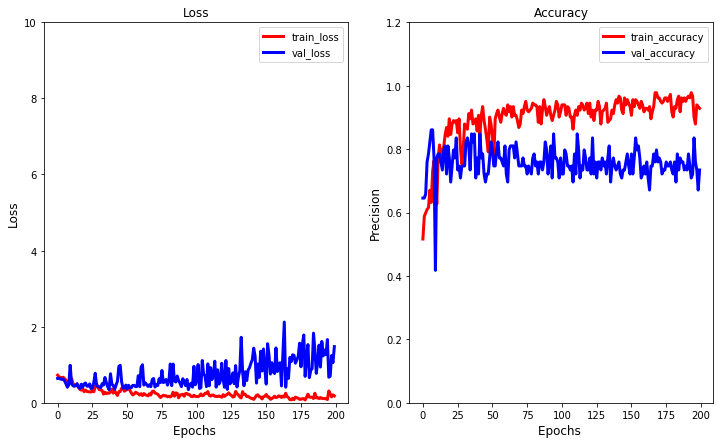

In [38]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [39]:
from metrics import confusion_matrix

### Training samples

In [40]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, X_train, y_train)

In [41]:
conf_matrix

array([[ 76.,   3.],
       [  3., 100.]])

In [42]:
print("Accuracy training: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall training: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion training: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy training: 96.70%
Recall training: 96.20%
Precicion training: 96.20%


### Validation samples

In [43]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, X_test, y_test)

In [44]:
conf_matrix

array([[ 8.,  1.],
       [20., 50.]])

In [45]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 73.42%
Recall testing: 28.57%
Precicion testing: 88.89%


# Shap analysis - Final version

In [46]:
import pandas as pd
import shap
# load JS visualization code to notebook
shap.initjs()

In [47]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

In [48]:
X_plot_df = pd.DataFrame(data=X_test[0])
# X_plot_df.columns = ['Timestamp', 'Capacity', 'OC', 'Ec_20_20', 'Ec_60_20', 'W_1_1',
#                      'W_20_20', 'Num_conflicts', 'Climb', 'Cruis', 'Desc']

X_plot_df.columns = ['fraction_of_cloud_cover_min', 
                     'fraction_of_cloud_cover_avg',
                     'fraction_of_cloud_cover_max',
                     'relative_humidity_min',
                     'relative_humidity_avg',
                     'relative_humidity_max',
                     'temperature_min',
                     'temperature_avg',
                     'temperature_max',
                     'u_component_of_wind_min',
                     'u_component_of_wind_avg',
                     'u_component_of_wind_max',
                     'v_component_of_wind_min',
                     'v_component_of_wind_avg',
                     'v_component_of_wind_max',
                     'vertical_velocity_min',
                     'vertical_velocity_avg',
                     'vertical_velocity_max',
                     'vorticity_min',
                     'vorticity_avg',
                     'vorticity_max',
                     'Timestamp', 
                     'Capacity', 'OC', 'Ec_20_20', 'Ec_60_20', 'W_1_1',
                     'W_20_20', 'Num_conflicts', 'Climb', 'Cruis', 'Desc']

shape_values_plot = shap_values[0][0]

In [49]:
# Collecting a grouping all the other information
for i in range(1, X_test.shape[0]):
    
    X_test_df_add = pd.DataFrame(data=X_test[i])
    X_test_df_add.columns = ['fraction_of_cloud_cover_min', 
                             'fraction_of_cloud_cover_avg',
                             'fraction_of_cloud_cover_max',
                             'relative_humidity_min',
                             'relative_humidity_avg',
                             'relative_humidity_max',
                             'temperature_min',
                             'temperature_avg',
                             'temperature_max',
                             'u_component_of_wind_min',
                             'u_component_of_wind_avg',
                             'u_component_of_wind_max',
                             'v_component_of_wind_min',
                             'v_component_of_wind_avg',
                             'v_component_of_wind_max',
                             'vertical_velocity_min',
                             'vertical_velocity_avg',
                             'vertical_velocity_max',
                             'vorticity_min',
                             'vorticity_avg',
                             'vorticity_max',
                             'Timestamp', 
                             'Capacity', 'OC', 'Ec_20_20', 'Ec_60_20', 'W_1_1',
                             'W_20_20', 'Num_conflicts', 'Climb', 'Cruis', 'Desc']
    
    X_plot_df = X_plot_df.append(X_test_df_add, ignore_index=True)
    
    shape_values_plot = np.append(shape_values_plot, 
                                  shap_values[0][i], 
                                  axis=0)

#     print(i)

In [50]:
X_plot_df.shape, shape_values_plot.shape

((2370, 32), (2370, 32))

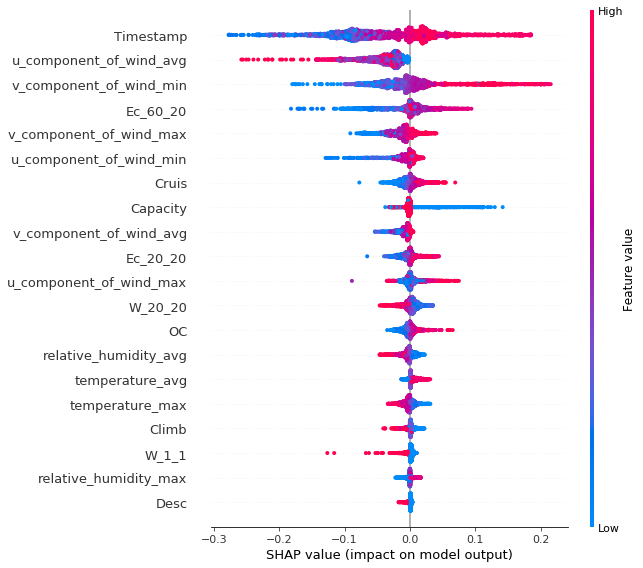

In [51]:
shap.summary_plot(shape_values_plot*10, X_plot_df)

In [52]:
sys.exit()

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [ ]:
shap.force_plot(explainer.expected_value, shape_values_plot, X_plot_df)

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Ec_60_20", shape_values_plot, X_plot_df)

In [ ]:
shap.summary_plot(shape_values_plot*100, X_plot_df, plot_type="bar")